In [10]:
import os
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score

from sklearn.ensemble import VotingClassifier

### 1. 검증용 데이터 분리

In [11]:
train_df = pd.read_csv('data/train_df.csv')
test_df = pd.read_csv('data/test_df.csv')

## 2. 컬럼별 데이터 분석

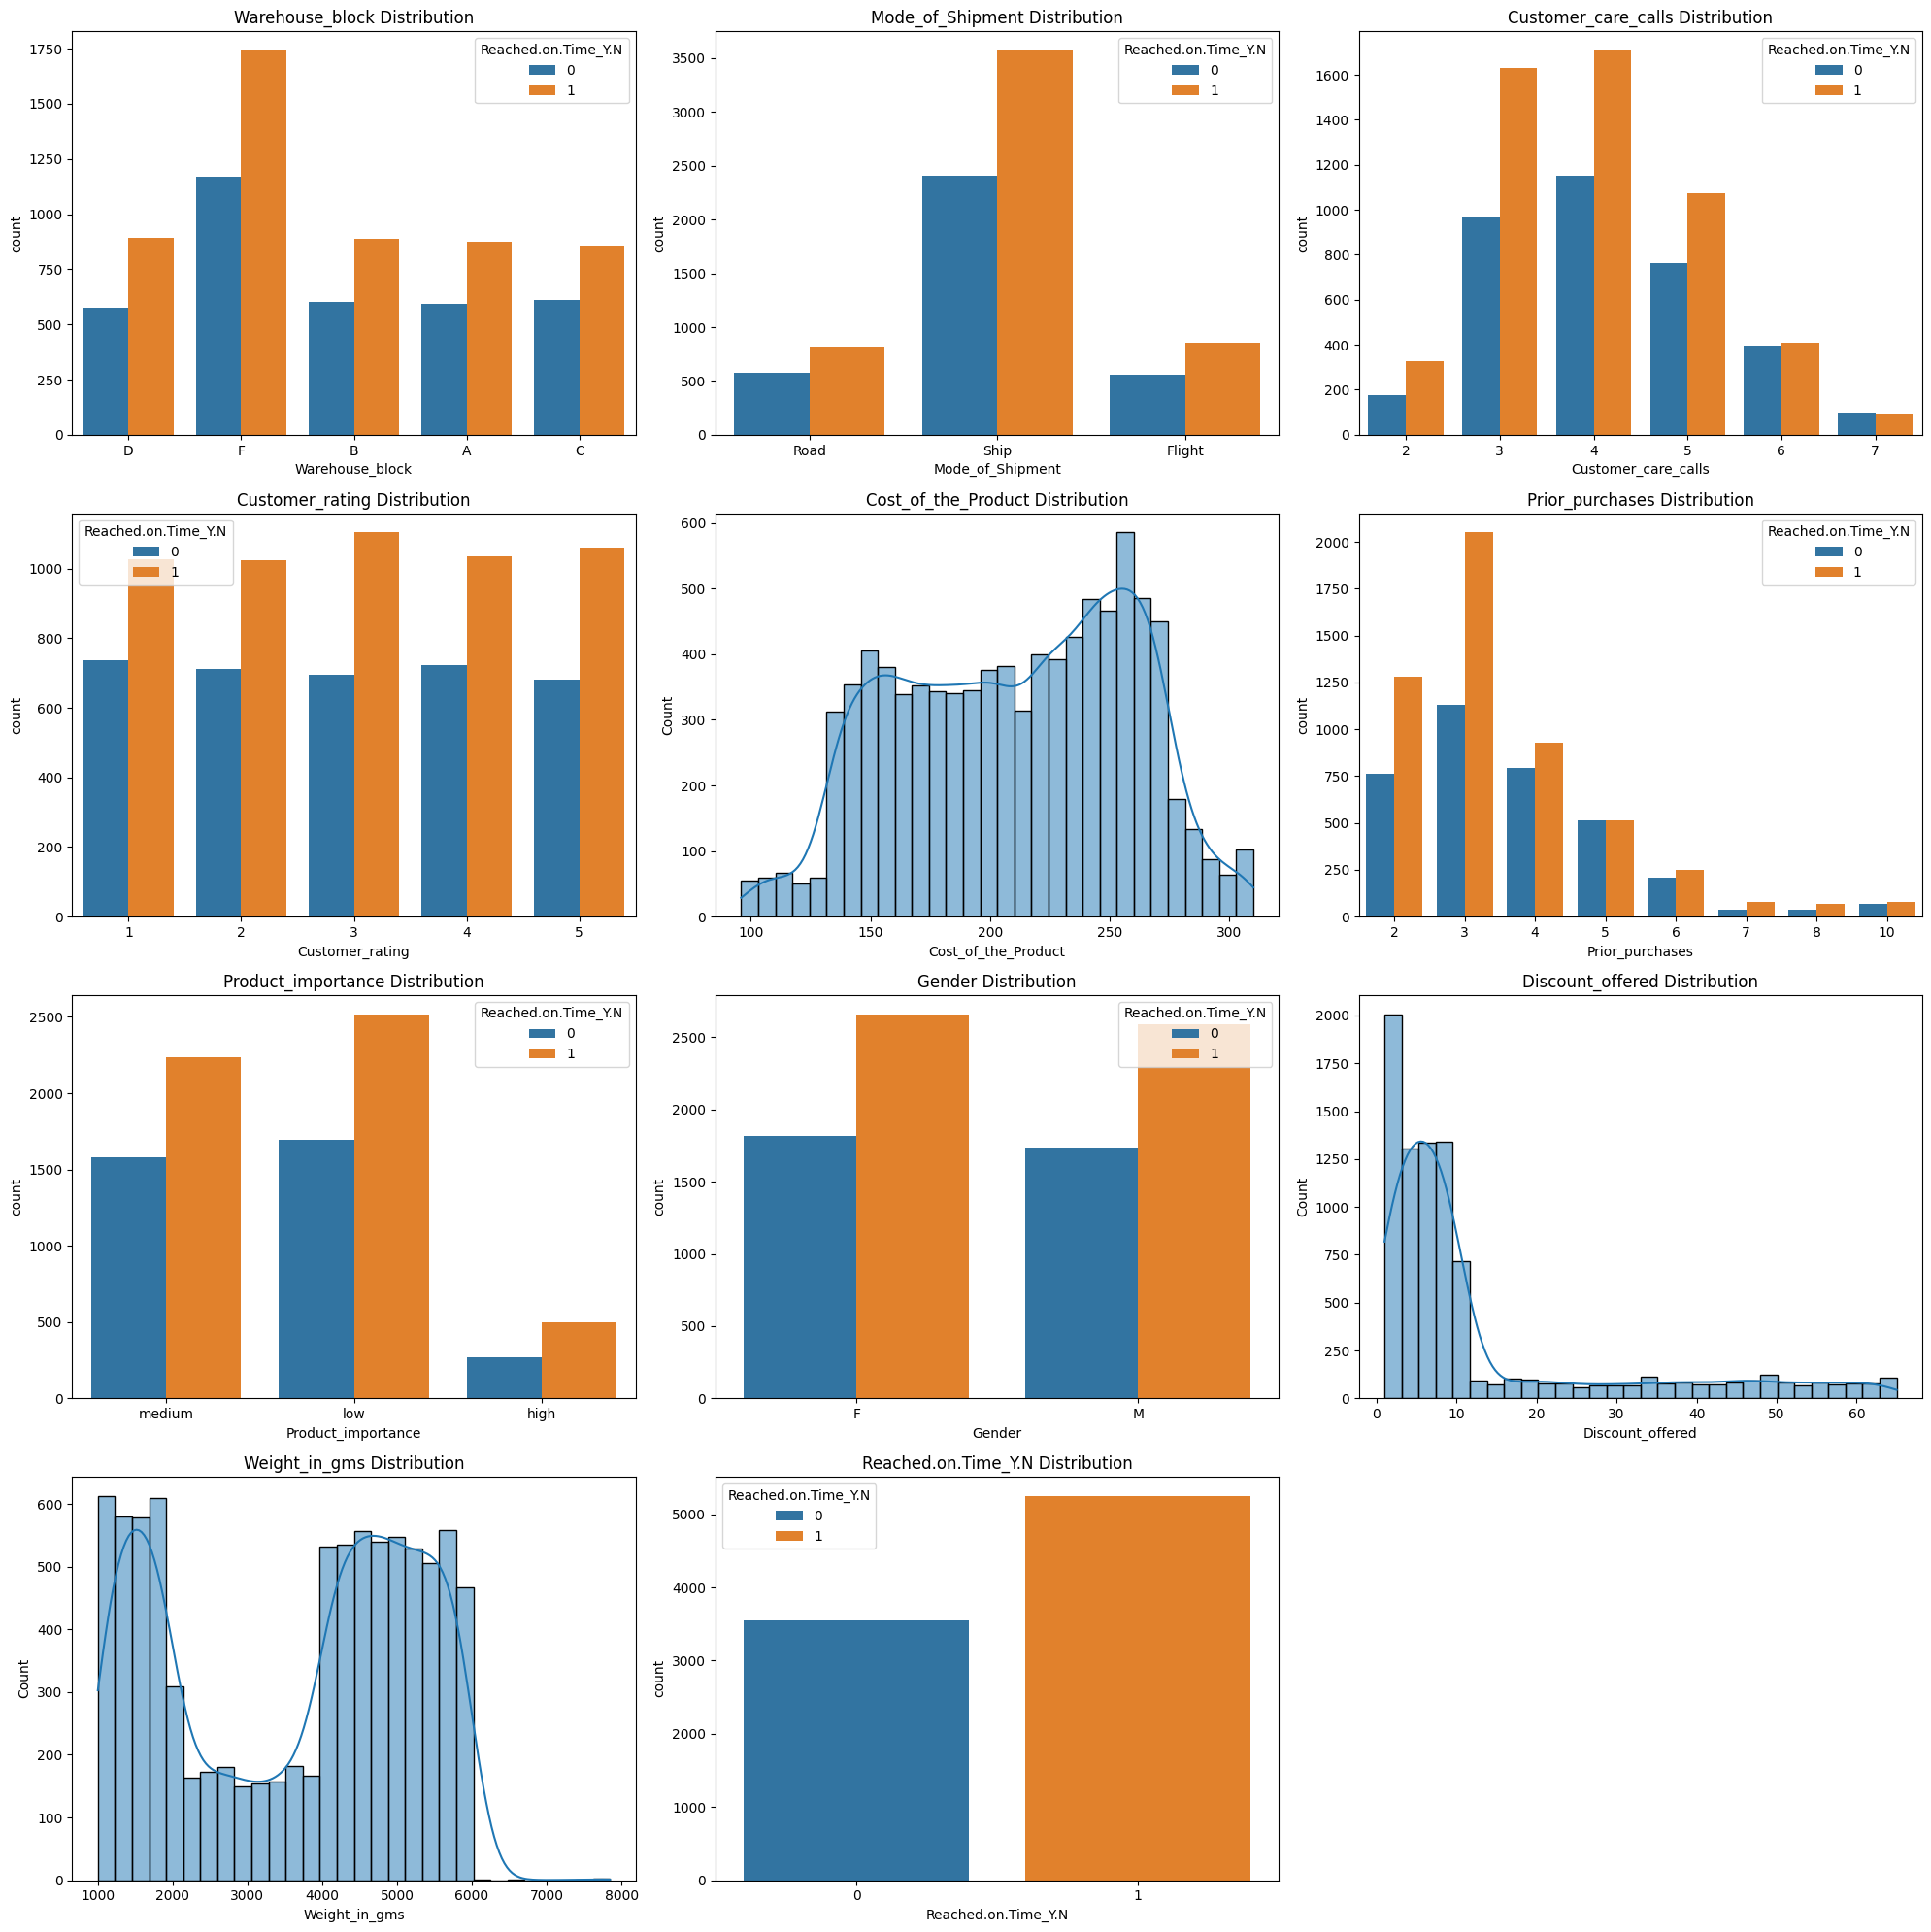

In [12]:
# 컬럼별 시각화
columns = train_df.columns.tolist()
columns.remove('ID') # ID는 시각화 제외

plt.figure(figsize=(20, 20))
for i, col in enumerate(columns, 1):
    plt.subplot(4, 3, i)
    if train_df[col].dtype == 'object' or train_df[col].nunique() < 10:
        sns.countplot(x=col, data=train_df, hue='Reached.on.Time_Y.N')
        plt.title(f'{col} Distribution')
    else:
        sns.histplot(train_df[col], kde=True, bins=30)
        plt.title(f'{col} Distribution')
    plt.tight_layout()
plt.show()

EDA 결과 : 할인율이 10%가 넘어가는 제품은 무게가 2~4kg되는 상품이 많음. (물건 판매량은 무게가 무거운 제품이 더 많으므로 판매량 때문은 아님)

할인율이 10%가 넘어가는 제품은 100% 지연 -> 별도의 저가 물류 프로세스를 타거나, 프로모션으로 인한 물량 폭주


## 3. 특성 엔지니어링

In [ ]:
# Feature Engineering
def engineer_features(all_data):
    # 할인율 10% 초과 여부 컬럼 생성 (Binary Feature) 10% 이하면 0, 10% 초과면 1
    all_data['is_high_discount'] = (all_data['Discount_offered'] > 10).astype(int)

    # 무게 구간별 분류 (Binning) 분석 결과 2kg~4kg가 핵심이므로, 이를 포함한 3개 구간으로 나눔.
    bins = [0, 2000, 4000, all_data['Weight_in_gms'].max()]
    labels = ['Low_Weight', 'Mid_Weight', 'High_Weight']
    all_data['weight_bin'] = pd.cut(all_data['Weight_in_gms'], bins=bins, labels=labels)

In [15]:
# 1. 합치기 (나중에 나누기 위해 행 개수 저장)
n_train = len(train_df)
all_data = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

# 추가로 컬럼 생성
engineer_features(all_data)

# 원-핫 인코딩 (Mode_of_Shipment)
all_data = pd.get_dummies(all_data, columns=['Mode_of_Shipment', 'weight_bin'])

# 라벨 인코딩
le = LabelEncoder()
for col in all_data.select_dtypes(include=['object']).columns:
    all_data[col] = le.fit_transform(all_data[col].astype(str))

# 불필요한 컬럼 삭제 
all_data = all_data.drop(['ID', 'Customer_care_calls', 'Customer_rating','Gender', 'Warehouse_block'], axis=1)

# 타겟 컬럼을 맨 뒤로 재배치
target_col = 'Reached.on.Time_Y.N'
cols = [c for c in all_data.columns if c != target_col] + [target_col]
all_data = all_data[cols]
# 원래 변수명 그대로 나누기 (기존 코드)
train_df = all_data.iloc[:n_train, :].copy()
test_df = all_data.iloc[n_train:, :].copy()

print(f"컬럼 개수 일치 확인: {train_df.shape[1]} == {test_df.shape[1]}")

컬럼 개수 일치 확인: 14 == 14


In [16]:
# 스케일링
numeric_cols = ['Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
scaler = StandardScaler()
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

## 4. 상관관계 분석 및 시각화

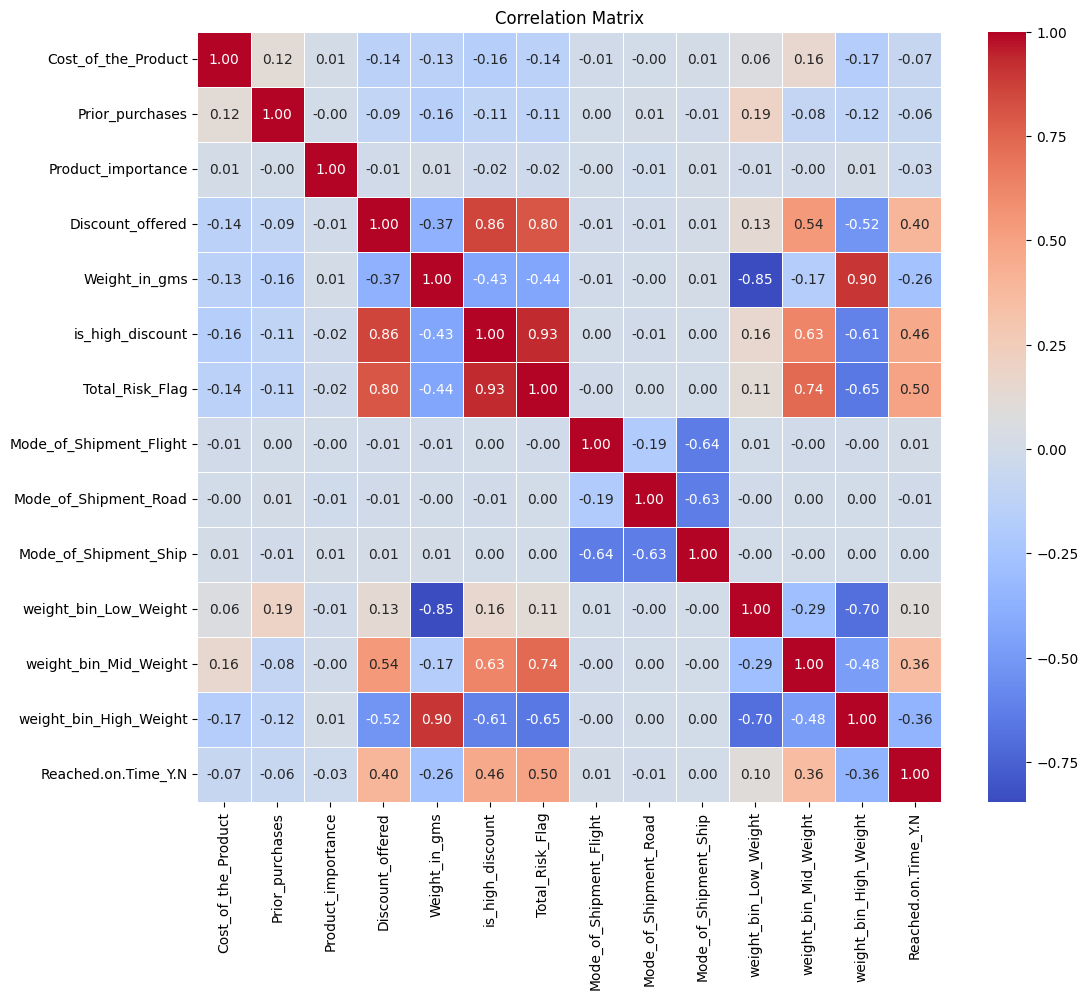

In [24]:
# 상관관계 매트릭스
corr_matrix = train_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## 5. 7가지 모델로 분석 후 성능 비교

In [18]:
# 1. 학습용 데이터
X_train = train_df.drop('Reached.on.Time_Y.N', axis=1)
y_train = train_df['Reached.on.Time_Y.N']

# 2. 테스트용 데이터
X_test = test_df.drop('Reached.on.Time_Y.N', axis=1)
y_test = test_df['Reached.on.Time_Y.N']

xgb_tuned = XGBClassifier(
                            n_estimators=1000,
                            learning_rate=0.05,
                            max_depth=6,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            random_state=42,
                            eval_metric='logloss',
                            verbosity=0
                        )
lgbm_tuned = LGBMClassifier(
                            n_estimators=1000, 
                            learning_rate=0.05, 
                            num_leaves=31, 
                            random_state=42, 
                            verbose=-1
                        )

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb_tuned,
    'LightGBM': lgbm_tuned
}

# 모델 학습 및 평가 결과를 저장할 딕셔너리
performance = {}

print("모델별 학습 및 평가 시작...")

for name, model in models.items():
    # 1. 모델 학습
    model.fit(X_train, y_train)
    
    # 2. 예측
    pred = model.predict(X_test)

    # ROC-AUC를 위해 '1(지연)'일 확률을 가져옴
    if hasattr(model, "predict_proba"):
        prob = model.predict_proba(X_test)[:, 1]
    else: # SVC 등 확률 제공 안 하는 설정일 경우 대비
        prob = model.decision_function(X_test)
    
    # 3. 평가지표 계산
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, prob) # AUC 추가
    
    # 4. 결과 저장
    performance[name] = {'acc': acc, 'f1': f1, 'auc': auc}
    print(f"완료: {name}")

# ROC-AUC 기준으로 정렬
sorted_performance = sorted(performance.items(), key=lambda x: x[1]['auc'], reverse=True)

# 5. 결과 출력
print("\n" + "="*55)
print(f"{'Model Name':<20} | {'Accuracy':<8} | {'F1':<8} | {'AUC':<8}")
print("-" * 55)

for name, scores in sorted_performance:
    print(f"{name:<20} | {scores['acc']:.4f}   | {scores['f1']:.4f}   | {scores['auc']:.4f}")
print("="*55)

모델별 학습 및 평가 시작...
완료: Random Forest
완료: AdaBoost
완료: Gradient Boosting
완료: XGBoost


Exception in thread Thread-5 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\user\miniconda3\envs\DS\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\user\miniconda3\envs\DS\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\user\miniconda3\envs\DS\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc0 in position 4: invalid start byte


완료: LightGBM

Model Name           | Accuracy | F1       | AUC     
-------------------------------------------------------
Gradient Boosting    | 0.6832   | 0.6598   | 0.7498
XGBoost              | 0.6682   | 0.7054   | 0.7436
Random Forest        | 0.6645   | 0.7017   | 0.7376
LightGBM             | 0.6559   | 0.6936   | 0.7347
AdaBoost             | 0.6605   | 0.6024   | 0.7155


마지막 변수 추가 전

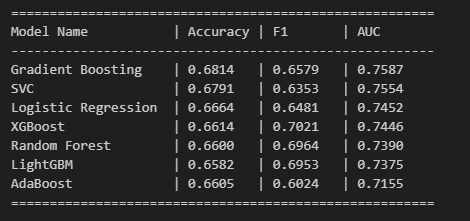

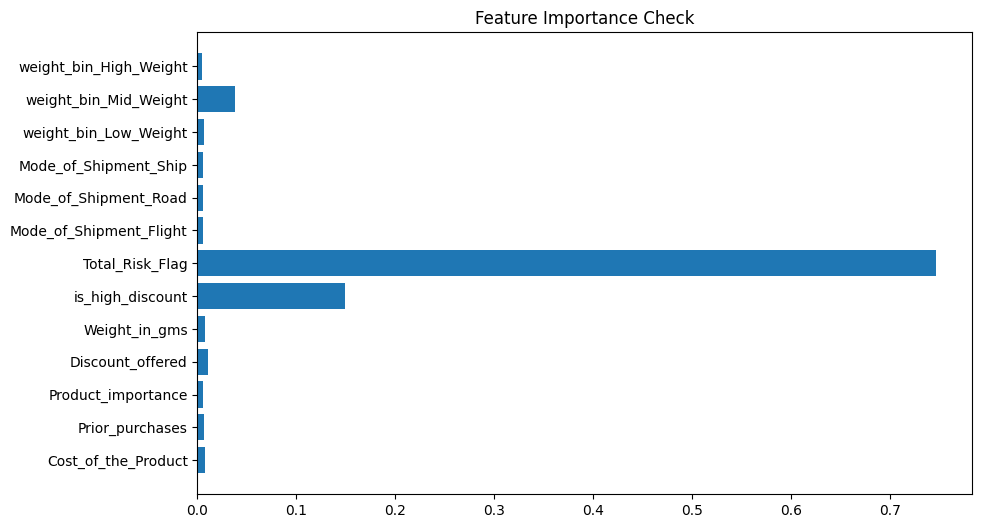

In [26]:
# 모델 기준 피처 중요도 확인
model = models['XGBoost'] # 학습된 모델
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, model.feature_importances_)
plt.title('Feature Importance Check')
plt.show()

## 6. 성능이 가장 좋은 3개 모델로 앙상블

In [20]:
# 상위 3개 모델 선택
top_3_models = [model_name for model_name, acc in sorted_performance[:3]]
print(f"Selected Top 3 Models: {top_3_models}")

estimators = [(name, models[name]) for name in top_3_models]

# 앙상블 모델 생성 (Soft Voting)
ensemble_model = VotingClassifier(estimators=estimators, voting='soft')
ensemble_model.fit(X_train, y_train)

# 앙상블 성능 평가
ensemble_pred = ensemble_model.predict(X_test)
ensemble_acc = accuracy_score(y_test, ensemble_pred)
print(f"Ensemble Model Accuracy: {ensemble_acc:.4f}")

Selected Top 3 Models: ['Gradient Boosting', 'XGBoost', 'Random Forest']
Ensemble Model Accuracy: 0.6686


### Gemini 추천 앙상블 성격이 다른 모델들 결합
(GBM + SVC + XGBoost) 앙상블과 (SVC + XGBoost) 앙상블 중에 후자가 더 결과가 좋게 나옴

- 공간분할(SVC)과 트리형(GBM, XGBoost)은 데이터를 바라보는 관점이 달라 서로 오답을 잘 보완해준다고 함
- GBM은 같은 트리계열이라 예측성향이 겹쳐서 도움이 되지 않은 듯 함.
- 튜닝을 고려하면 무거운 GBM 제외하는 게 좋을 것 같음

svc : 데이터들 사이의 거리를 최대화하는 최적의 경계를 찾는 모델 (공간분할)

In [21]:
use_cpu = round(os.cpu_count()*(2/3))
use_cpu

15

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 1. 모델별 파라미터 그리드 설정
# GBM: 현재 1위 모델이므로 가장 정교하게 튜닝
# param_gbm = {
#     'n_estimators': [100, 200],
#     'learning_rate': [0.05, 0.1],
#     'max_depth': [3, 4, 5]
# }

# XGBoost: F1-Score의 강점을 AUC로 전환하기 위한 튜닝
param_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5, 7],
    # 'use_label_encoder': [False],
    'eval_metric': ['logloss']
}

# SVC: 확률 기반 Voting을 위해 probability=True 필수
# 파이프라인을 사용해 스케일링과 튜닝을 동시에 진행
param_svc = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto']
}

# 2. GridSearchCV 실행 (각각) 
# print("GBM 튜닝 중...")
# grid_gbm = GridSearchCV(GradientBoostingClassifier(random_state=42), param_gbm, cv=5, scoring='roc_auc', n_jobs=use_cpu)
# grid_gbm.fit(X_train, y_train)

print("XGBoost 튜닝 중...")
grid_xgb = GridSearchCV(XGBClassifier(random_state=42), param_xgb, cv=5, scoring='roc_auc', n_jobs=use_cpu)
grid_xgb.fit(X_train, y_train)

print("SVC 튜닝 중...")
svc_pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(probability=True, random_state=42))])
grid_svc = GridSearchCV(svc_pipe, param_svc, cv=5, scoring='roc_auc', n_jobs=use_cpu)
grid_svc.fit(X_train, y_train)

# 3. 최적의 모델들로 Soft Voting 앙상블 결성
# best_gbm = grid_gbm.best_estimator_
best_xgb = grid_xgb.best_estimator_
best_svc = grid_svc.best_estimator_

ensemble_model = VotingClassifier(
    # estimators=[('gbm', best_gbm), ('xgb', best_xgb), ('svc', best_svc)],
    estimators=[('xgb', best_xgb), ('svc', best_svc)],
    voting='soft'
)

ensemble_model.fit(X_train, y_train)

# 앙상블 모델의 확률값 예측 (soft voting이므로 predict_proba 사용)
ensemble_pred_proba = ensemble_model.predict_proba(X_test)[:, 1]

# 최종 AUC 계산
final_auc = roc_auc_score(y_test, ensemble_pred_proba)

print("\n--- 튜닝 및 앙상블 완료 ---")
# print(f"Best GBM AUC: {grid_gbm.best_score_:.4f}")
print(f"Best XGB AUC: {grid_xgb.best_score_:.4f}")
print(f"Best SVC AUC: {grid_svc.best_score_:.4f}")
print(f"최종 앙상블 모델 AUC: {final_auc:.4f}")

XGBoost 튜닝 중...
SVC 튜닝 중...

--- 튜닝 및 앙상블 완료 ---
Best XGB AUC: 0.7417
Best SVC AUC: 0.7406
최종 앙상블 모델 AUC: 0.7501


## 7. 앙상블 모델 성능 분석 후 시각화

C:\Users\user\AppData\Local\Temp\ipykernel_6544\617465692.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=model_names, palette='magma')


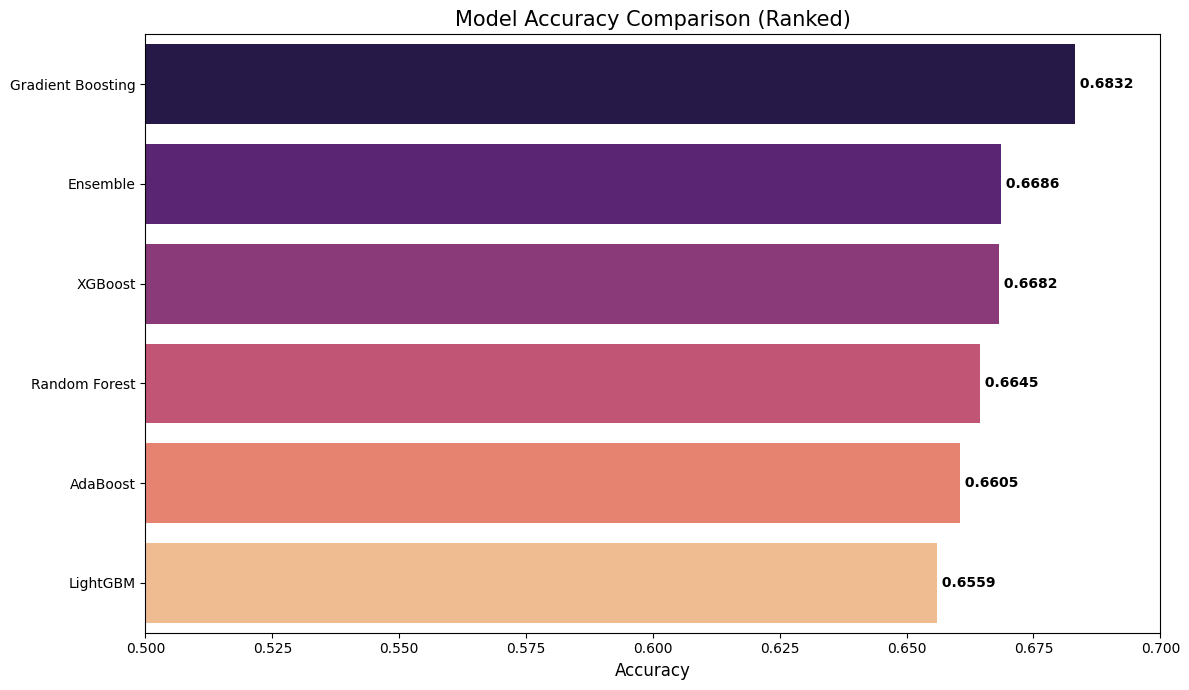

In [23]:
# 성능 비교 시각화
# 1. 기존 모델들의 결과에서 'acc' 값만 추출하여 앙상블 모델 결과와 형식을 맞춤
all_performance = [(name, scores['acc']) for name, scores in sorted_performance] + [('Ensemble', ensemble_acc)]

# 2. 성적(Accuracy) 기준 내림차순 정렬
# x[1]은 정확도 값을 의미 (이제 모든 데이터의 x[1]이 float이므로 정상적으로 정렬됨)
all_performance_sorted = sorted(all_performance, key=lambda x: x[1], reverse=True)

# 3. 시각화를 위한 데이터 분리
model_names = [name for name, _ in all_performance_sorted]
accuracies = [acc for _, acc in all_performance_sorted]

# 4. 차트 그리기
plt.figure(figsize=(12, 7))
# 정확도 순서대로 정렬되었으므로 palette도 순서에 맞게 적용
sns.barplot(x=accuracies, y=model_names, palette='magma')

plt.title('Model Accuracy Comparison (Ranked)', fontsize=15)
plt.xlabel('Accuracy', fontsize=12)
plt.xlim(0.5, 0.7)  # 차이를 극대화하기 위해 범위를 데이터에 맞춰 조정

# 수치 표시
for i, v in enumerate(accuracies):
    plt.text(v, i, f" {v:.4f}", va='center', fontweight='bold')

plt.tight_layout()
plt.show()